# Using CALAMITI as a prior. CALAMITI is trained on 0.8mm isotropic T1/T2 brains on all three orientations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../kaisr

/home/remedios/kaisr/kaisr


In [3]:
import nibabel as nib
import numpy as np
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import torch

from utils.plot import *
from tqdm import tqdm
from models.convnext_ae import *
import lpips

from utils.kernel import *
from utils.train_loader_patches import normalize
from resize.scipy import resize
from utils.ilo import *

In [4]:
def mse(a, b):
    return ((a - b) ** 2).sum()

In [5]:
torch.backends.cudnn.benchmark = True
set_display_mode(mode='dark')
DTYPE = np.float32
device = torch.device(f'cuda:0')

In [6]:
# lr_fpath = Path("../../data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled.nii")
# hr_fpath = Path("../../data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-01mm_resampled.nii")

lr_fpath = Path("../../data/old/OASIS3/OASIS3_04x_aniso/sub-OAS30003_ses-d0558_run-01_T1w.nii")
hr_fpath = Path("../../data/old/OASIS3/OASIS3_iso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")

# lr_fpath = Path("../../data/old/IXI_old/IXI-T1_4x_aniso/ds4_axial_IXI012-HH-1211-T1.nii.gz")
# hr_fpath = Path("../../data/old/IXI_old/IXI-T1_almost_iso/IXI012-HH-1211-T1.nii.gz")

In [7]:
lr_vol = nib.load(lr_fpath).get_fdata(dtype=DTYPE)
gt_vol = nib.load(hr_fpath).get_fdata(dtype=DTYPE)
center_slice_idx = lr_vol.shape[0] // 2
gt = gt_vol[center_slice_idx]
gt, *_ = normalize(gt, a=0, b=2)

In [8]:
scale = 4

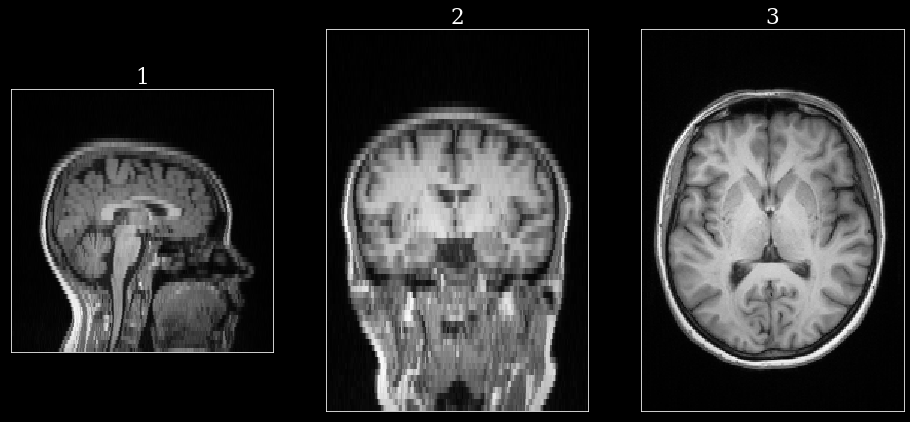

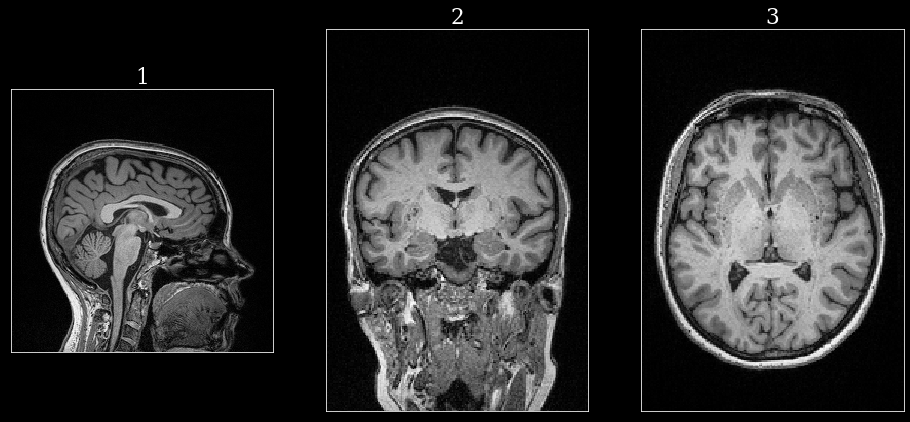

In [9]:
center_vol_plot(lr_vol, target_shape=gt_vol.shape)
center_vol_plot(gt_vol)

# Load CALAMITI

In [10]:
from models.CALAMITI.model import CALAMITI
from models.CALAMITI.utils import create_one_hot

In [11]:
weight_fpath = Path("../weights/CALAMITI_1p0mm_epoch007_batch7000.pt")
calamiti_model = CALAMITI(
    beta_dim=4, 
    theta_dim=2, 
    pretrained_model=weight_fpath,
    gpu=device,
)

# Compressed Sensing

In [12]:
obs = lr_vol[center_slice_idx]

pad = 0
obs = np.pad(obs, ((0, 0), (pad, 0)))
obs, orig_min, orig_max = normalize(obs, a=0, b=2)

obs_interp = resize(obs, (1, 1/scale), order=5)
obs_interp = torch.from_numpy(obs_interp).unsqueeze(0).unsqueeze(1).to(device)

obs = torch.from_numpy(obs).to(device)
y = obs

In [13]:
fwhm = 0.5#fwhm_needed(1, scale)
std = fwhm_to_std(fwhm)
slice_profile = gaussian(M=17, std=std, sym=True).astype(np.float32)
slice_Profile = np.array([0., 1., 0.])
A = DegradationKernel(
    scale_factor=1/scale, 
    lr_dims=(256, 256),
    blur_kernel=slice_profile,
    device=device, 
    mode='linear',
).to(device)

### Reform the CALAMITI decoder as a list

In [14]:
calamiti_model.decoder

Unet(
  (in_conv): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downconv_0): ConvBlock2d(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): LeakyReLU(negative_slope=0.01)
    )
  )
  (maxpool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample_0): Upsample(
    (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (act): LeakyReLU(negative_slope=0.01)
  )
  (upconv_0): ConvBlock2d(
    (conv): Sequential(
      (0): Conv2d(64, 32, kernel_size=

In [15]:
G = calamiti_model.decoder
# ensure G is frozen
for p in G.parameters():
    p.requires_grad=False

In [16]:
# set up loss functions
losses = {
    'mse': torch.nn.MSELoss().to(device),
    'tv': TotalVariation().to(device),
    'l1': torch.nn.L1Loss().to(device),
}

In [17]:
from pytorch_wavelets import DWTForward

In [18]:
forward_dwt = DWTForward(J=3, wave='haar').to(device)

# Just CSGM

In [19]:
lr = 1e-1
n_iters = 5000
mse_lambda = 1
tv_lambda = 1e-6
wavelet_lambda = 0

In [20]:
theta_init = torch.randn((1, 2, 1, 1), requires_grad=True, device=device)
beta_init = torch.randn((1, 4, 256, 256), requires_grad=True, device=device)

In [21]:
opt = torch.optim.Adam([theta_init, beta_init], lr=lr)

with tqdm(total=n_iters) as pbar:    
    pbar_dict = {
        'loss': np.finfo(np.float32).max,
        'mse': np.finfo(np.float32).max,
        'tv': np.finfo(np.float32).max,
        'wavelet': np.finfo(np.float32).max,
    }
    for _ in range(n_iters):
        opt.zero_grad()
        
        z = torch.cat([beta_init, theta_init.repeat(1, 1, *beta_init.shape[-2:])], dim=1)

        x_hat = G(z)
        y_hat = A(x_hat)
        
        # L1 loss on wavelet detail coefficients
        _, wavelet_details = forward_dwt(x_hat)
        wavelet_details = torch.concat(
            [wd.flatten(start_dim=-2, end_dim=-1) for wd in wavelet_details], 
            dim=-1,
        )
        zero_details = torch.zeros_like(wavelet_details)

        mse_loss = losses['mse'](y_hat, y)
        tv_loss = losses['tv'](x_hat) # smoothness in HR estimate
        wavelet_loss = losses['l1'](wavelet_details, zero_details)
        
        loss = mse_lambda * mse_loss + \
            tv_lambda * tv_loss + \
            wavelet_lambda * wavelet_loss

        loss.backward()
        opt.step()

        pbar_dict['loss'] = loss.detach().cpu().numpy().item()
        pbar_dict['mse'] = mse_loss.detach().cpu().numpy().item()
        pbar_dict['tv'] = tv_loss.detach().cpu().numpy().item()
        pbar_dict['wavelet'] = wavelet_loss.detach().cpu().numpy().item()
        pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
        pbar.update(1)

100%|████████████████████████████████████████████████████████████| 5000/5000 [01:17<00:00, 64.15it/s, loss=0.0040, mse=0.0007, tv=3296.7268, wavelet=0.0366]


In [22]:
betas_post = create_one_hot(z[:, :4, ...], dim=1).detach().cpu().numpy().squeeze()
thetas_post = z[:, 4:, ...].detach().cpu().numpy().squeeze().mean(axis=(1, 2))

In [23]:
pred = G(z).detach().cpu().numpy().squeeze()

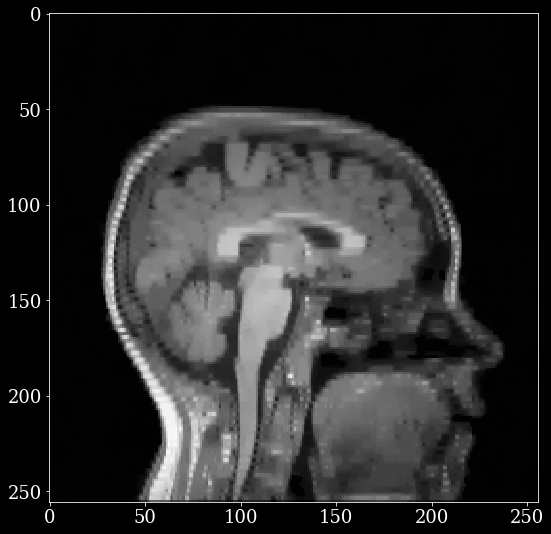

In [24]:
plt.imshow(np.rot90(pred[:, int(pad*scale):]))

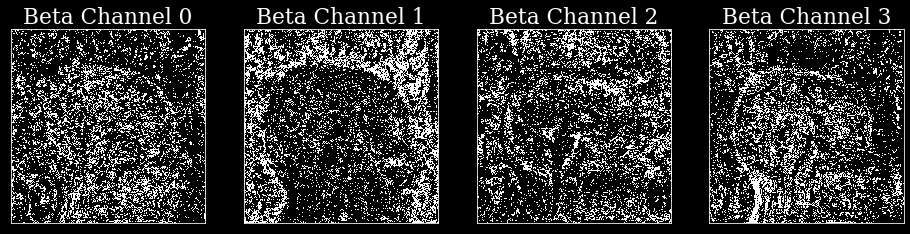

In [25]:
multiplot(
    betas_post,
    titles=[f"Beta Channel {i}" for i in range(4)]
)

In [26]:
thetas_post

array([-2.077822 ,  1.3637307], dtype=float32)

# Evalution

In [27]:
deg_csgm = A(torch.from_numpy(pred).to(device)).detach().cpu().numpy().squeeze()

In [28]:
gt.shape

(256, 256)

Interp MSE: 691.93915
CSGM MSE: 885.1436
Degraded CSGM MSE: 11.524324


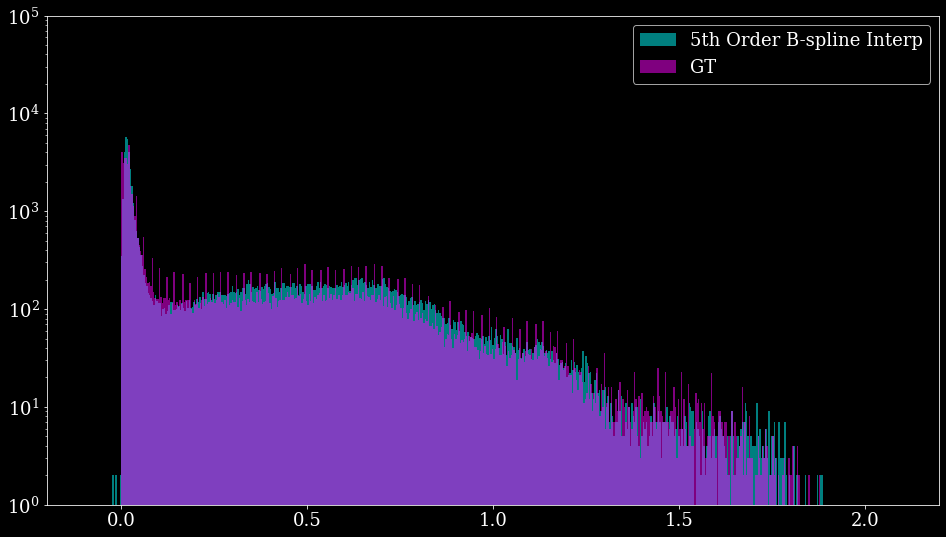

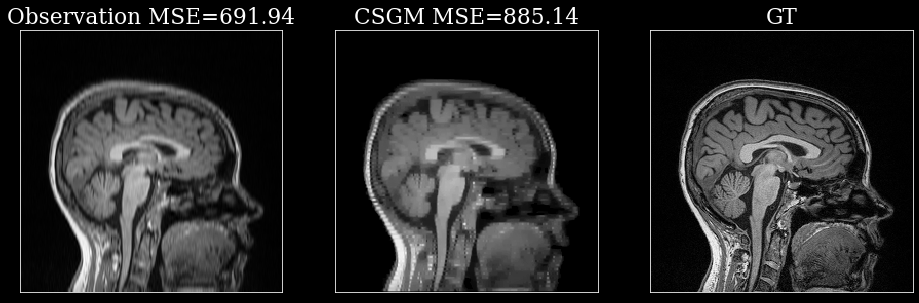

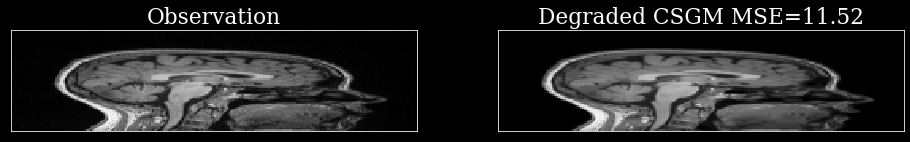

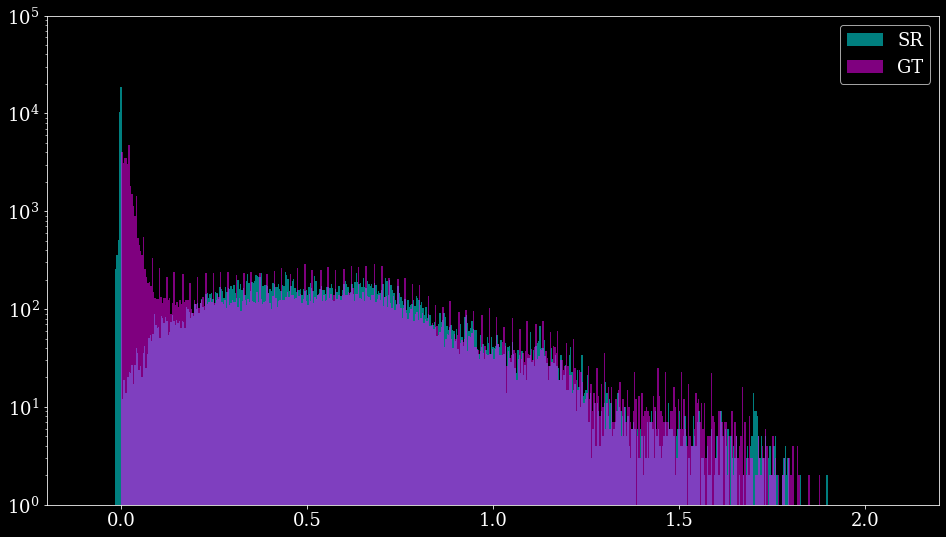

In [29]:
vmin = gt.min()
vmax = gt.max()

interp_mse = mse(obs_interp.detach().cpu().numpy().squeeze()[:, int(pad*scale):], gt)
csgm_mse = mse(pred[:, int(pad*scale):], gt)
deg_csgm_mse = mse(deg_csgm, obs.detach().cpu().numpy())

print("Interp MSE:", interp_mse)
print("CSGM MSE:", csgm_mse)
print("Degraded CSGM MSE:", deg_csgm_mse)
plt.hist(obs_interp.detach().cpu().numpy().flatten(), bins=512, color='cyan', alpha=0.5, label='5th Order B-spline Interp')
plt.hist(gt.flatten(), bins=512, color='magenta', alpha=0.5, label='GT')
plt.yscale('log')
plt.legend()
plt.xlim((-0.2, 2.2))
plt.ylim((1, 10**5))
plt.show()

multiplot(
    [obs_interp.detach().cpu().numpy().squeeze()[:, int(pad*scale):], pred[:, int(pad*scale):], gt],
    titles=[
        f'Observation MSE={interp_mse:.2f}', 
        f'CSGM MSE={csgm_mse:.2f}', 
        f'GT',
    ],
    vmins=[vmin, vmin, vmin],
    vmaxs=[vmax, vmax, vmax],
)


multiplot(
    [
        obs.detach().cpu().numpy().squeeze()[:, pad:], 
        deg_csgm[:, pad:],
    ],
    titles=['Observation', f'Degraded CSGM MSE={deg_csgm_mse:.2f}'],
    vmins=[vmin, vmin],
    vmaxs=[vmax, vmax],
)

plt.hist(pred.flatten(), bins=512, color='cyan', alpha=0.5, label='SR')
plt.hist(gt.flatten(), bins=512, color='magenta', alpha=0.5, label='GT')
plt.yscale('log')
plt.xlim((-0.2, 2.2))
plt.ylim((1, 10**5))
plt.legend()
plt.show()